In [1]:
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['figure.figsize'] = [20, 10]

np.random.seed(7)

N_SECTIONS = 50

In [2]:
N, M = 300, 300
PROBABILITY = 0.997
mat = np.random.rand(N, M) >= PROBABILITY

In [3]:
def read_mtx(file, boolean=True):
    with open(file) as f:
        s = f.readline()
        symmetric = True if s.startswith("%%MatrixMarket") and "symmetric" in s else False

        while s.startswith("%"):
            s = f.readline()
        N, M, _ = map(int, s.split())

        mat = np.zeros((N, M), dtype=bool) if boolean else np.zeros((N, M), dtype=float)

        for line in f:
            i, j = map(int, line.split()[:2])
            value = 1 if boolean else float(line.split()[2])
            
            mat[i - 1, j - 1] = value
            if symmetric:
                mat[j - 1, i - 1] = value
    return mat, N, M

In [4]:
mat_paths = {
    "first": "../matrices/first/C_sparsity.mtx",
    "jan99jac060sc": "../../tests/jan99jac060sc.mtx",
    "c-22": "../../tests/c-22.mtx",
    "1138_bus": "../../tests/1138_bus.mtx",
    "viscoplastic2": "../../tests/viscoplastic2.mtx"
}

mat, N, M = read_mtx(mat_paths["first"], boolean=True)

In [5]:
mat = mat.astype(bool)

In [6]:
SEC_SIZE = N // N_SECTIONS

In [7]:
def print_mat(mat):
    for i in range(N):
        if i % SEC_SIZE == 0:
            print("-" * ((M + N_SECTIONS) * 2 + 1))
        for j in range(M):
            if j % SEC_SIZE == 0:
                print("|", end=" ")
            print(f"{mat[i][j]}", end=" ") if mat[i][j] != 0 else print(" ", end=" ")
        print("|")
    print("-" * ((M + N_SECTIONS) * 2 + 1))
    print()

def show_mat(mat, show=False):
    if mat.shape[0] < 1000 or show == True:
        plt.figure()
        plt.imshow(mat, cmap="binary")

In [8]:
print("Non-zeros: ", np.sum(mat))
print(f"Non-zeros ratio: {np.sum(mat) / (N * M) * 100:.2f}%")

Non-zeros:  3067
Non-zeros ratio: 11.27%


In [9]:
def get_sections(mat):
    return (np.add.reduceat(np.add.reduceat(mat, np.arange(0, N, SEC_SIZE), axis=0),
                        np.arange(0, M, SEC_SIZE), axis=1) > 0).astype(bool)

def iteration(mat, i, shuffled_rows=None, shuffled_cols=None):
    mat = mat.T if i % 2 != 0 else mat

    indices = [np.nonzero(row)[0] for row in mat]
    indices = [x if len(x) > 0 else [M] for x in indices]
    shuffling = np.argsort([np.mean(x) for x in indices])
    sorted_mat = mat[shuffling]
    sorted_mat = sorted_mat.T if i % 2 != 0 else sorted_mat

    if not (shuffled_rows.any() == None and shuffled_cols.any() == None):
        if i % 2 != 0:
            shuffled_rows = shuffled_rows[shuffling]
        else:
            shuffled_cols = shuffled_cols[shuffling]
        
    sorted_sec_indices = get_sections(sorted_mat)
    return sorted_mat, sorted_sec_indices, shuffled_rows, shuffled_cols

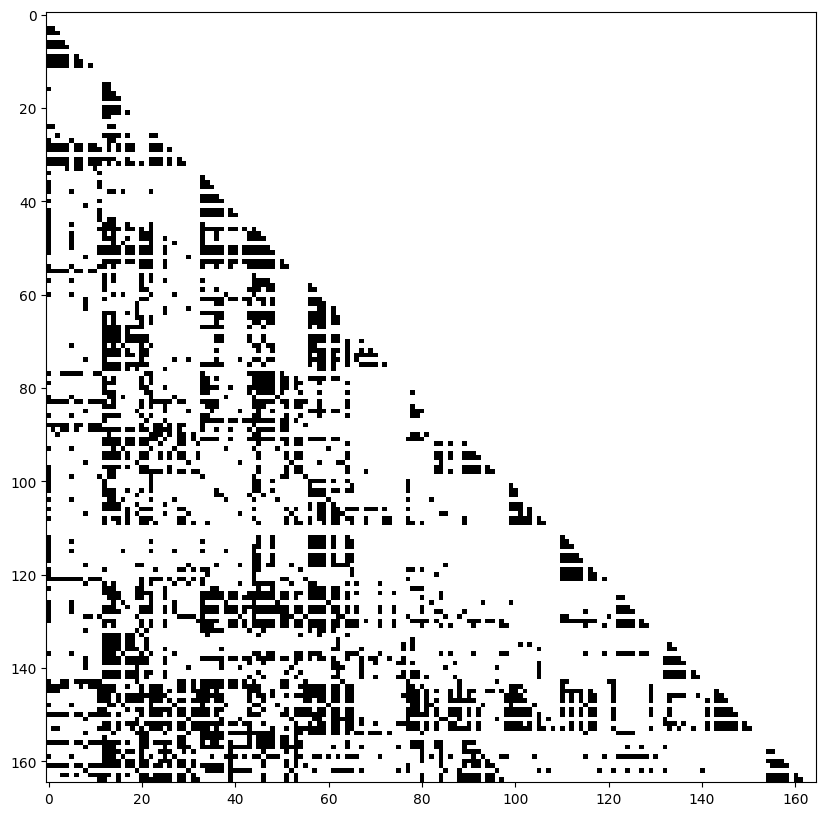

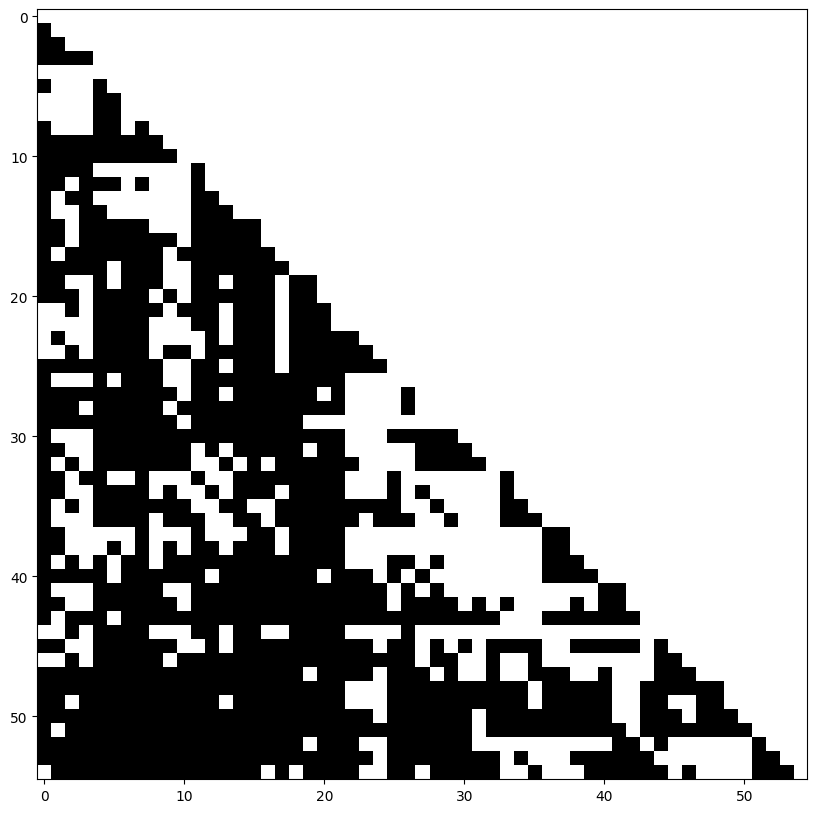

In [10]:
show_mat(mat, show=True)

sec_indices = get_sections(mat)
show_mat(sec_indices)

In [11]:
sorted_mat = mat
shuffled_rows = np.arange(N)
shuffled_cols = np.arange(M)

fig = plt.figure()
frames = []
frames.append([plt.imshow(sec_indices, cmap="binary", animated=True)])
for i in tqdm(range(100)):
    sorted_mat, sorted_sec_indices, shuffled_rows, shuffled_cols = \
        iteration(sorted_mat, i, shuffled_rows=shuffled_rows, shuffled_cols=shuffled_cols)
    frames.append([plt.imshow(sorted_sec_indices, cmap="binary", animated=True)])
plt.close()

100%|██████████| 100/100 [00:00<00:00, 1176.67it/s]


In [12]:
ani = animation.ArtistAnimation(fig, frames, interval=300, blit=True, repeat_delay=1000)
ani.save('tmp.mp4')

In [13]:
print("Non-zeros in sec_indices: ", np.sum(sec_indices))
print(f"Non-zeros ratio in sec_indices: {np.sum(sec_indices) / (N // SEC_SIZE * M // SEC_SIZE) * 100:.2f}%")

print("Non-zeros in sorted_sec_indices: ", np.sum(sorted_sec_indices))
print(f"Non-zeros ratio in sorted_sec_indices: {np.sum(sorted_sec_indices) / (N // SEC_SIZE * M // SEC_SIZE) * 100:.2f}%")

Non-zeros in sec_indices:  1015
Non-zeros ratio in sec_indices: 33.55%
Non-zeros in sorted_sec_indices:  1191
Non-zeros ratio in sorted_sec_indices: 39.37%


In [14]:
def check_correctness():
    shuffled_rows = np.arange(N)
    shuffled_cols = np.arange(M)

    sorted_mat = mat
    for i in tqdm(range(100)):
        sorted_mat, sec_indices, shuffled_rows, shuffled_cols = iteration(sorted_mat, i, shuffled_rows=shuffled_rows, shuffled_cols=shuffled_cols)

    A = read_mtx("../matrices/first/A.mtx", boolean=False)
    B = read_mtx("../matrices/first/B.mtx", boolean=False)
    C = A.dot(B)

    C_real = read_mtx("../matrices/first/C_expected.mtx", boolean=False)

    A = A[shuffled_rows]
    B = B[:, shuffled_cols]
    C_shuffled = A.dot(B)

    C_shuffled = C_shuffled[shuffled_rows]
    C_shuffled = C_shuffled[:, shuffled_cols]

    print(np.sum(C_real - C_shuffled))
    print(np.sum(C - C_shuffled))